In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as st
import numpy as np
from scipy.optimize import fsolve
import math
from pyteomics import pepxml
import random
import os
import glob
from collections import deque
import pickle
import importlib as imp
import lower as low
imp.reload(low)
lows = low.Tools()

In [35]:
#parse the scores from the pepxml files
paths = glob.glob(os.path.join("/data/dominik/lower_order/extra_test/", "*new.pep.xml"))
paths



['/data/dominik/lower_order/extra_test/C_S24_new.pep.xml']

In [2]:
#input: pepxml files, output: np arrays (TEV score, charge, N)

def parse_pepxmls(paths):

    tev = deque()
    charges = deque()
    big_n  = deque()

    for path in paths:
        print(path)
        cur_file = pepxml.read(path)

        for spec in cur_file:
            if 'search_hit' in spec.keys():
                if len(spec['search_hit']) == 10:
                    tev.append(list(map(lambda x: -0.02*np.log(spec['search_hit'][x]['search_score']['expect']/500), np.arange(10))))
                    charges.append(int(spec['assumed_charge']))
                    big_n.append(int(spec['search_hit'][0]['num_matched_peptides']))

    return tev, charges, big_n

In [36]:
tev, charges, big_n = parse_pepxmls(paths)

/data/dominik/lower_order/extra_test/C_S24_new.pep.xml


In [6]:
pickle.dump(tev, open("tev_18.pkl", "wb"))
pickle.dump(charges, open("charges_18.pkl", "wb"))
pickle.dump(big_n, open("big_n_18.pkl", "wb"))

In [3]:
#get only tevs of selected charge

def filter_charge(tev, charges, big_n, ch):
    t = np.array(tev)
    c = np.array(charges)
    n = np.array(big_n)
    mask = np.where((c == ch))
    return t[mask], n[mask]


In [4]:
tev = pickle.load(open("tev_18.pkl", "rb"))
charges = pickle.load(open("charges_18.pkl", "rb"))
big_n = pickle.load(open("big_n_18.pkl", "rb"))

In [38]:

tev3, n3  = filter_charge(tev, charges, big_n, 3)
tev2, n2  = filter_charge(tev, charges, big_n, 2)

In [53]:
pickle.dump(big_n, open("big_n_dhp.pkl", "wb"))

In [6]:
#1 objective 1: estimate parameters for each hit separately, then plot the linear regression
def lower_params(arr):
    n0 = []
    a = []

    for hit in range(10):
        print(hit)
        cur_tev = arr[:,hit].astype('float128')
        cur_n0, cur_a = lows.mle_universal(cur_tev, hit)
        n0.append(cur_n0)
        a.append(cur_a)
    return n0, a

def plot_fitted(arr, N0, a, alpha, col='blue', frac=1):
    sorted_arr = np.array(sorted(arr))
    l_lim = sorted_arr[0]
    u_lim = sorted_arr[-1]
    pdf = lows.pdf_universal(sorted_arr, N0, a, alpha)
    plt.plot(sorted_arr, frac*pdf,color=col)
    sns.distplot(sorted_arr, bins = np.linspace(0, 0.8, 600), kde=False, norm_hist=True,
                hist_kws=dict(histtype='step', linewidth=0.5, color='black'))
    plt.xlim(l_lim, u_lim)

def plot_params(n0, a, outname = ""):

    trim_n0 = list(n0)[2:]
    trim_a = list(a)[2:]
    linreg = st.linregress(trim_n0, trim_a)
    print(linreg)

    fig = plt.figure(figsize=(6,6))
    plt.scatter(trim_n0, trim_a, marker='*', color='royalblue')
    plt.plot([min(trim_n0), max(trim_n0)], 
                [min(trim_n0)*linreg.slope + linreg.intercept, 
                max(trim_n0)*linreg.slope + linreg.intercept], color='grey')
    plt.xlabel('N0')
    plt.ylabel("a")

    if outname != "":
        fig.savefig(f'./graphs/{outname}.png', dpi=400, bbox_inches='tight')

In [41]:
def get_params(tevs):
    n0, a = lower_params(tevs)
    trim_n0 = list(n0)[3:]
    trim_a = list(a)[3:]
    linreg = st.linregress(trim_n0, trim_a)

    return n0, a, linreg

n03, a3, linreg = get_params(tev3)
#n1, a1 = np.log(np.log(n02)), np.log(-np.array(a2))


0
1
2
3
4
5
6
7
8
9


LinregressResult(slope=1.614733377172611e-05, intercept=-0.024732630917814788, rvalue=0.8953150969996616, pvalue=0.0026476167184743982, stderr=3.279684202588157e-06, intercept_stderr=0.0006270328748579024)


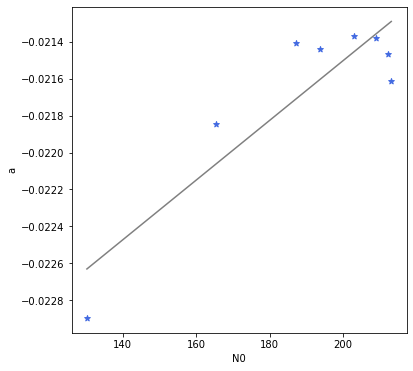

In [23]:
#plot_params(n02, a2)
plot_params(n02, a2)

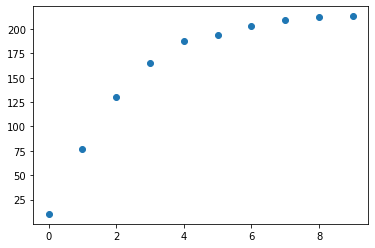

In [28]:
plt.scatter(np.arange(10), n02)

In [58]:
n1 = np.log(np.log(n02))
a1 = np.log(-np.array(a2))

In [32]:
linreg = st.linregress(n02[3:6], a2[3:6])
linreg

LinregressResult(slope=1.574804116698771e-05, intercept=-0.024431981979759307, rvalue=0.9585570938208756, pvalue=0.18392112666655142, stderr=4.680602661988541e-06, intercept_stderr=0.000854428277741378)

LinregressResult(slope=-1.2806912893769107, intercept=-1.7011709517044098, rvalue=-0.9998535308813188, pvalue=7.854716316327832e-12, stderr=0.008949619567776795, intercept_stderr=0.01584485322244892)


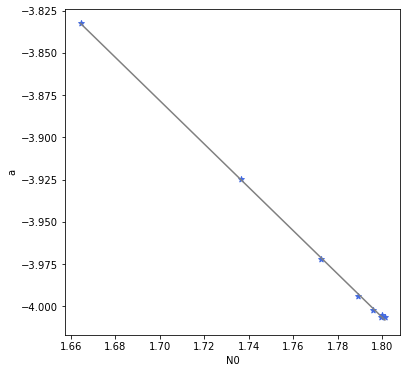

In [61]:

plot_params(n1, a1)

In [12]:
linreg = st.linregress(n1[3:], a1[3:])
linreg

LinregressResult(slope=-0.8658125608408648, intercept=-2.395154444131305, rvalue=-0.9997528639615837, pvalue=1.843896505236147e-09, stderr=0.008609985638534224, intercept_stderr=0.014925153872835648)

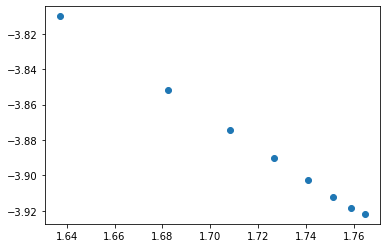

In [11]:
plt.scatter(n1[2:], a1[2:])

/data/dominik/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


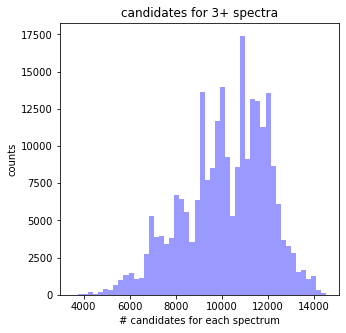

In [153]:
fig = plt.figure(figsize=(5,5))
sns.distplot(n3, bins = 50, kde=False, norm_hist=False,
                hist_kws=dict(histtype='stepfilled', linewidth=1, color='blue'))
plt.xlabel("# candidates for each spectrum")
plt.ylabel("counts")
plt.title("candidates for 3+ spectra")
plt.savefig(f"./graphs/n3.png", dpi=600,bbox_inches='tight')
#plt.xlim(0, 0.2)

In [35]:
linreg = st.linregress(n03[2:], a3[2:])
linreg

LinregressResult(slope=1.3245898448020321e-05, intercept=-0.024212646769005936, rvalue=0.9882070967560443, pvalue=4.063994136841325e-06, stderr=8.379131477258874e-07, intercept_stderr=0.00023586505199628185)

In [195]:
linreg = st.linregress(n1[3:], a1[3:])
linreg

LinregressResult(slope=-1.387990638337416, intercept=-1.4485057596226318, rvalue=-0.9988649928693726, pvalue=8.330790164587094e-08, stderr=0.029599594947057804, intercept_stderr=0.05498612904170342)

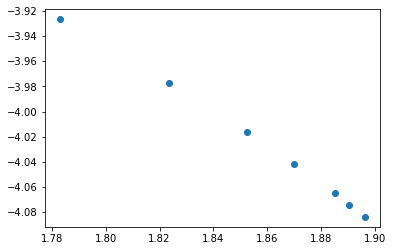

In [194]:
plt.scatter(n1[3:], a1[3:])

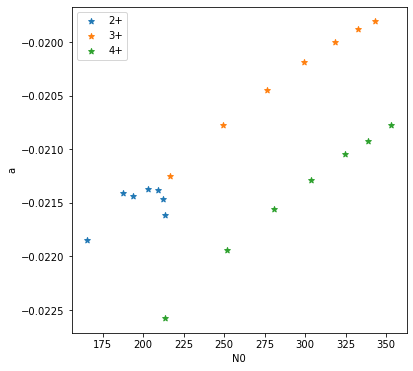

In [76]:
#plt.scatter(n022[2:], a22[2:])
fig = plt.figure(figsize=(6,6))
plt.scatter(n022[3:], a22[3:], marker="*")
plt.scatter(n033[3:], a33[3:], marker="*")
plt.scatter(n044[3:], a44[3:], marker="*")
plt.legend(['2+', '3+', '4+'])
plt.xlabel("N0")
plt.ylabel("a")
plt.savefig("./graphs/comparison_params.png", dpi=600, bbox_inches='tight')
#plt.scatter(n034[2:], a34[2:])

/tmp/ipykernel_841619/2688463256.py:5: RuntimeWarning: divide by zero encountered in log
  return a*np.log(x) + b


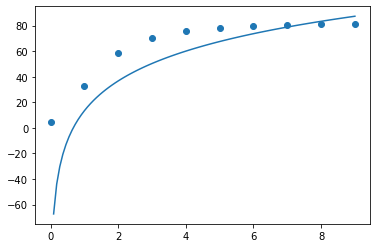

In [192]:
from scipy.optimize import curve_fit

def test_function(x, a, b):
    #return np.multiply(np.power(x,0.5),a) + np.multiply(x, b) + c
    return a*np.log(x) + b

popt, pcov = curve_fit(test_function, range(1,10, n0all)
plt.plot(np.linspace(0,9, 100), test_function(np.linspace(0,9, 100), *popt))
plt.scatter(range(10), n0all)

In [15]:
def plot_sam(tev, n0, a, idx, tit):
    fig = plt.figure(figsize=(6,6))
    cur_tev = tev[:,idx]
    plot_fitted(cur_tev, n0[idx], a[idx], idx)
    plt.xlim(min(cur_tev)*0.99, 0.15)
    plt.xlabel("TEV")
    plt.ylabel("density")
    plt.title(f"{tit}")
    #plt.savefig(f"./graphs/{idx}_tev2.png", dpi=600, bbox_inches = 'tight')

/data/dominik/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


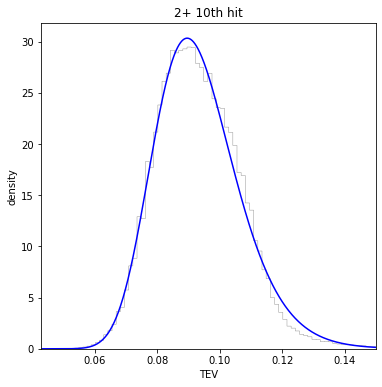

In [25]:
plot_sam(tev3, n03, a3, 2, '2+ 10th hit')

In [9]:
# generate quantiles
def get_quantiles(tev, outname):

    emps = sorted(tev)
    emps_df = pd.DataFrame(emps)

    emps_df[1] = emps_df.index + 1
    emps_df[2] = emps_df[1]/len(emps)

    #quantile optimization
    errors = []
    qq_range = np.linspace(50, 400, 1000)
    for i in qq_range:
        cur_a = i*linreg.slope + linreg.intercept
        theor_q = lows.gumbel_ppf(emps_df[2].to_numpy()[:-1], i, cur_a)
        diffs = theor_q - emps_df[0].to_numpy()[:-1]

        length = len(emps_df[2][emps_df[2] < 0.12])

        """
        diffs = abs(np.sum(diffs[:int(0.2*len(diffs))]))
        diffs = diffs/len(theor_q[:int(0.2*len(theor_q))])
        """

        diffs = abs(np.sum(diffs[:length]))
        diffs = diffs/len(theor_q[:length])

        #diffs = abs(np.sum(diffs))/len(diffs)
        errors.append(diffs)

    opt_idx = errors.index(min(errors))
    opt_N0 = qq_range[opt_idx]
    opt_a = opt_N0*linreg.slope + linreg.intercept

    fig = plt.figure(figsize=(6,6))
    plt.semilogy(qq_range, errors)
    plt.scatter(qq_range, errors, s=1)
    #plt.xlim(60,70)
    plt.xlabel("N0")
    plt.ylabel("loss")
    plt.savefig(f"./graphs/1{outname}.png", dpi=600, bbox_inches='tight')

    theor_q = lows.gumbel_ppf(emps_df[2].to_numpy()[:-1], opt_N0, opt_a)
    emps_q = emps_df[0].to_numpy()[:-1]

    fig1 = plt.figure(figsize=(6,6))
    plt.plot([0, 1], [0, 1], color='k')
    plt.scatter(theor_q, emps_q, s=1)

    plt.xlim(0, 0.2)
    plt.ylim(0, 0.2)
    plt.xlabel("theoretical quantile")
    plt.ylabel('empirical quantile')
    plt.savefig(f"./graphs/2{outname}.png", dpi=600, bbox_inches='tight')

    print(opt_N0, opt_a)

    

In [26]:
# generate quantiles
def get_quantiles(tev, outname):

    emps = sorted(tev)
    emps_df = pd.DataFrame(emps)

    emps_df[1] = emps_df.index + 1
    emps_df[2] = emps_df[1]/len(emps)

    #quantile optimization
    errors = []
    qq_range = np.linspace(0.5, 2, 1000)
    for i in qq_range:
        cur_a = i*linreg.slope + linreg.intercept
        theor_q = lows.gumbel_ppf(emps_df[2].to_numpy()[:-1], np.exp(np.exp(i)), -np.exp(cur_a))
        diffs = theor_q - emps_df[0].to_numpy()[:-1]

        length = len(emps_df[2][emps_df[2] < 0.2])

        """
        diffs = abs(np.sum(diffs[:int(0.2*len(diffs))]))
        diffs = diffs/len(theor_q[:int(0.2*len(theor_q))])
        """

        diffs = abs(np.sum(diffs[:length]))
        diffs = diffs/len(theor_q[:length])

        #diffs = abs(np.sum(diffs))/len(diffs)
        errors.append(diffs)

    opt_idx = errors.index(min(errors))
    opt_N0 = qq_range[opt_idx]
    opt_a = opt_N0*linreg.slope + linreg.intercept

    fig = plt.figure(figsize=(6,6))
    plt.semilogy(qq_range, errors)
    plt.scatter(qq_range, errors, s=1)
    #plt.xlim(60,70)
    plt.xlabel("N0")
    plt.ylabel("loss")
    plt.savefig(f"./graphs/1{outname}.png", dpi=600, bbox_inches='tight')

    theor_q = lows.gumbel_ppf(emps_df[2].to_numpy()[:-1], np.exp(np.exp(opt_N0)), -np.exp(opt_a))
    emps_q = emps_df[0].to_numpy()[:-1]

    fig1 = plt.figure(figsize=(6,6))
    plt.plot([0, 1], [0, 1], color='k')
    plt.scatter(theor_q, emps_q, s=1)

    plt.xlim(0, 0.2)
    plt.ylim(0, 0.2)
    plt.xlabel("theoretical quantile")
    plt.ylabel('empirical quantile')
    plt.savefig(f"./graphs/2{outname}.png", dpi=600, bbox_inches='tight')

    print(np.exp(np.exp(opt_N0)), -np.exp(opt_a))

    

248.64864864864865 -0.020202360486894774


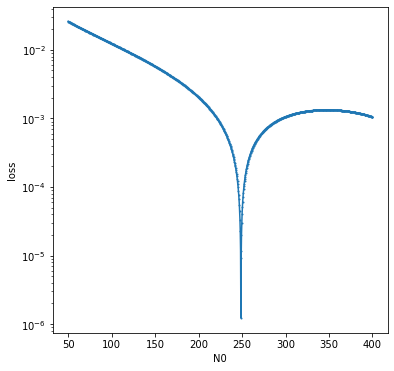

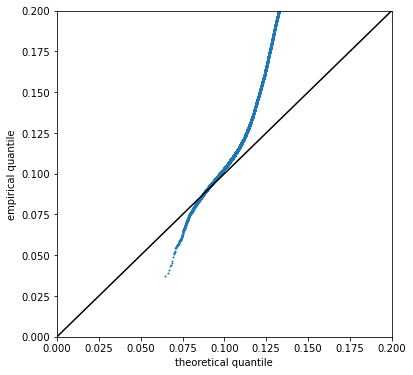

In [40]:
get_quantiles(tev3[:,0], 'test')

/data/dominik/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


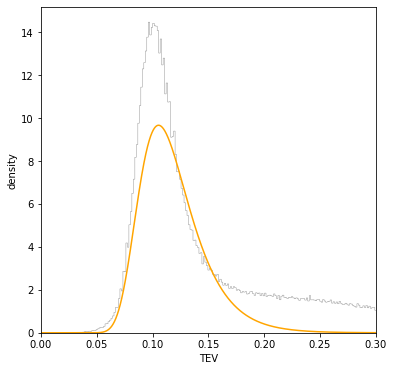

In [34]:
idx = 0
fig = plt.figure(figsize=(6,6))
#plot_fitted(tev3[:,idx], 323.3226452905812, -0.019269727693981706, idx, col='orange', frac=0.78)
#plot_fitted(tev3[:,idx], 387.3867735470942, -0.01798203934914556, idx, frac=0.72)
#plot_fitted(tev2[:,idx], 387.3867735470942, -0.01798203934914556, idx, frac=0.58)
#plot_fitted(tev2[:,idx], 57.0561122244489, -0.02925903843616671, idx, frac=1)

plot_fitted(tev2[:,idx], 100.8008008008008, -0.02284456681908297, idx, col='orange', frac=0.6)

#plot_fitted(tev3[:,idx], 355.3547094188377, -0.018625883521563632, idx, frac=0.75)
plt.xlim(0.0, 0.3)
plt.xlabel("TEV")
plt.ylabel("density")
plt.savefig("./graphs/test_ch2_new.png", dpi=600, bbox_inches="tight")

In [482]:
# investigate if mixing realization of RVs with different finite N will make a difference on the final distribution's parameters

def finite_gumbel_ppf(p, n0, n, a):
    q1 = n/n0
    q2 = 1 - np.power(p, 1/n)
    return a*np.log(q1*q2)

random.seed()
uni = st.uniform.rvs(0, 1, (200, 10000))
gf1 = finite_gumbel_ppf(uni, 500, 8000, -0.02)

random.seed()
uni = st.uniform.rvs(0, 1, (200, 10000))
gf2 = finite_gumbel_ppf(uni, 500, 16000, -0.02)

comb = list(map(lambda x: np.append(gf1[x], gf2[x]), np.arange(len(gf1))))
params = list(map(lambda x: lows.mle_universal(comb[x], 0), np.arange(len(comb))))



In [501]:
single = st.uniform.rvs(0, 1, 10000)
final = list(map(lambda x: finite_gumbel_ppf(single, 500, x, -0.02), np.arange(8000, 40000, 200)))

In [502]:
params = list(map(lambda x: lows.mle_universal(final[x], 0), np.arange(len(final))))

In [503]:
first = list(map(lambda x: params[x][0], range(len(params))))
second = list(map(lambda x: params[x][1], range(len(params))))

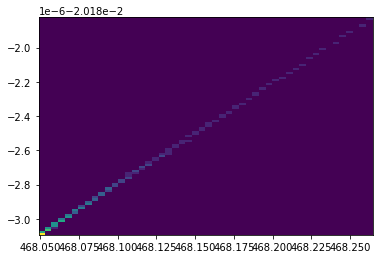

In [509]:
plt.hist2d(first, second, bins=(50,100))
plt.show()

LinregressResult(slope=6.847439010638688e-06, intercept=-0.02343163010524571, rvalue=0.9789700856459279, pvalue=1.8147686659405207e-69, stderr=1.4413985482176785e-07, intercept_stderr=7.26473613889131e-05)

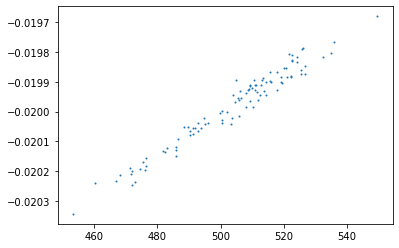

In [464]:
plt.scatter(first, second, s=1)
st.linregress(first, second)

/data/dominik/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

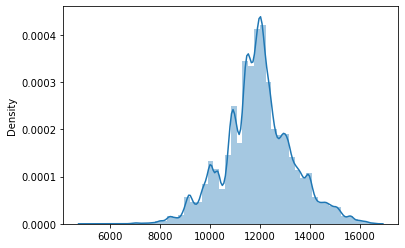

In [481]:
sns.distplot(n2)

In [436]:
lows.mle_universal(comb, 0)

(569.8833414608304, -0.019513073083921816)

In [444]:
comb = list(map(lambda x: np.append(gf1[x], gf2[x]), np.arange(len(gf1))))

In [446]:
comb[0]

array([0.12797813, 0.13747195, 0.12301538, 0.14723193, 0.12593523,
       0.10613851, 0.15866248, 0.14113831, 0.09274398, 0.13157378,
       0.16100582, 0.12419323, 0.1791919 , 0.1234106 , 0.11932847,
       0.15010683, 0.15089805, 0.11125594, 0.13323871, 0.13103674])